## This is an advanced lane finding project
The pipeline can be designed following the steps below:

 * Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
 * Apply a distortion correction to raw images.
 * Use color transforms, gradients, etc., to create a thresholded binary image.
 * Apply a perspective transform to rectify binary image ("birds-eye view").
 * Detect lane pixels and fit to find the lane boundary.
 * Determine the curvature of the lane and vehicle position with respect to center.
 * Warp the detected lane boundaries back onto the original image.
 * Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

## Import necessary packages

In [35]:
import numpy as np
import cv2
import glob
import os
import pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

## Calculate calibration parameters from calibration images

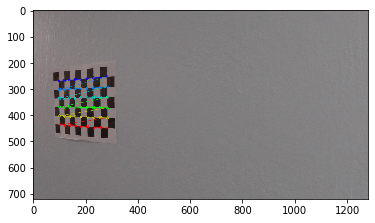

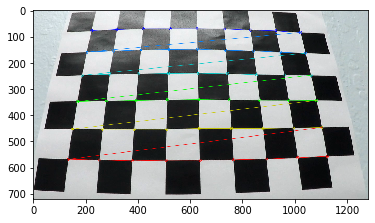

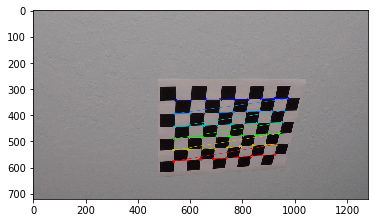

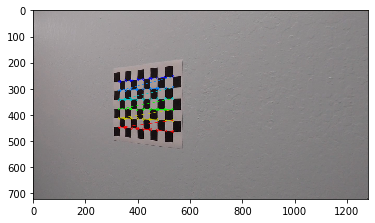

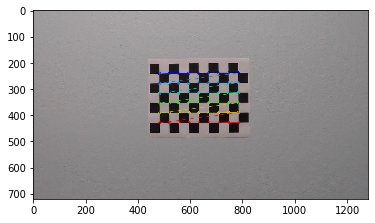

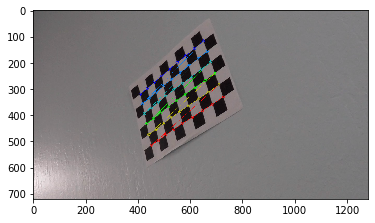

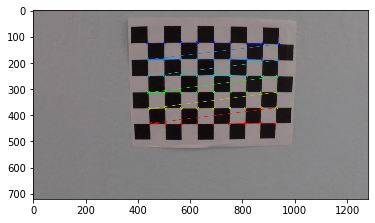

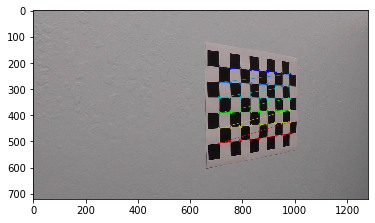

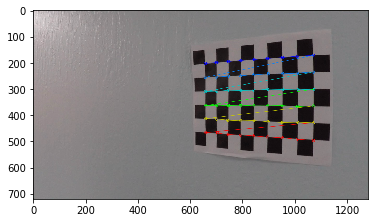

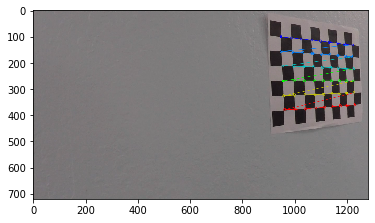

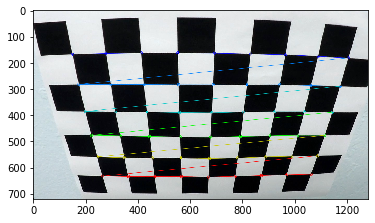

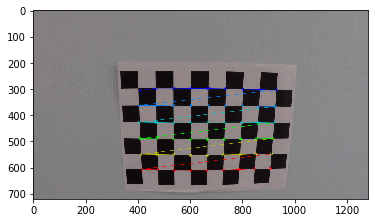

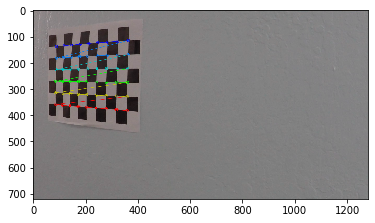

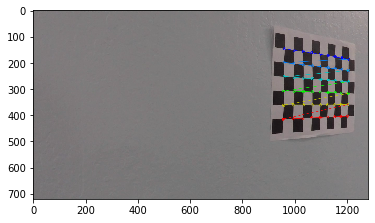

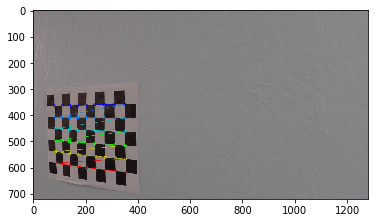

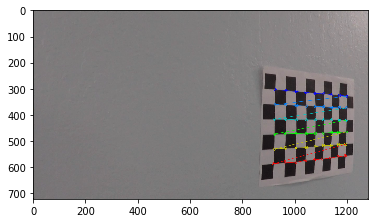

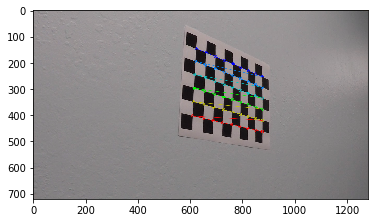

In [36]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        
        cv2.imwrite(os.path.join('./corners_marked_images/',fname[13:]), img)
        #print(fname[13:])
        #cv2.imshow('img',img)
        #cv2.waitKey(0)
        plt.figure()    
    #plt.imshow(img)
        plt.imshow(img)
#print(images)
#cv2.destroyAllWindows()

## THE FIRST FEW SECTION WILL EXPLORE THE PIPELINE STEP BY STEP IN TESTIMAGES

### Skip to the next section with capitilized caption for processing video

## Correct for distortion in images

In [37]:
def cal_undistort(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera() and cv2.undistort()
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1],None,None)
    #pickle.dump()
    undist= cv2.undistort(img, mtx, dist, None, mtx)
    #undist = np.copy(img)  # Delete this line
    return [undist, ret, mtx, dist]



# Make a list of calibration images
raw_images = glob.glob('./test_images/*.jpg')
#print(raw_images)

for fname2 in raw_images:
    img2 = cv2.imread(fname2)
    undistorted, ret, mtx, dist = cal_undistort(img2, objpoints, imgpoints)
    cv2.imwrite(os.path.join('./calibrated_images/',fname2[14:]), undistorted)
    #print(fname2[14:])

## Create a thresholded binary image

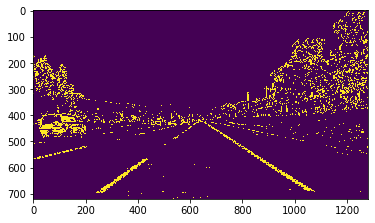

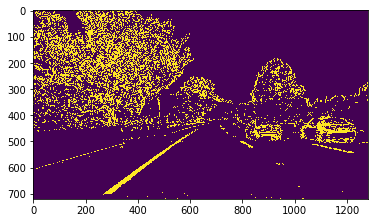

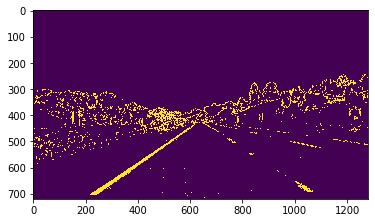

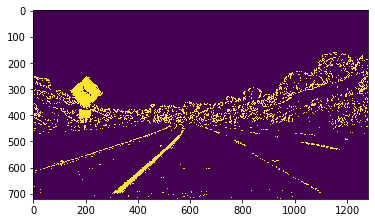

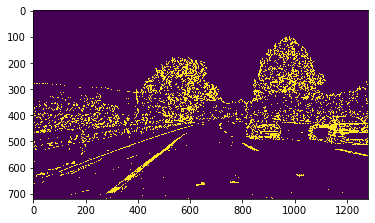

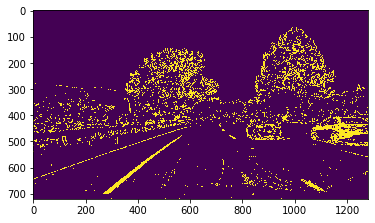

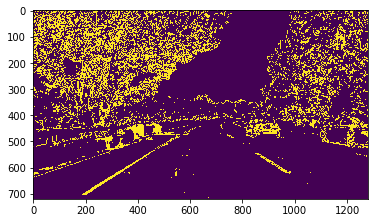

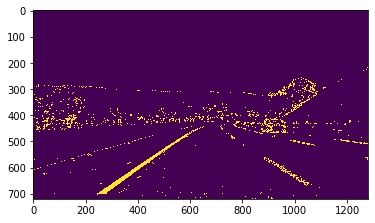

In [38]:
def binary_transformation(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    binary=cv2.bitwise_or(sxbinary,s_binary)
    
    # Stack each channel
    #color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    return binary
    


# Make a list of calibration images
calibrated_images = glob.glob('./calibrated_images/*.jpg')
#print(raw_images)

for fname3 in calibrated_images:
    img3 = cv2.imread(fname3)
    binary_images = binary_transformation(img3)
    #binary_images.dtype='uint8'
    cv2.imwrite(os.path.join('./binary_images/',fname3[20:]), binary_images*255)
    #print(fname3[20:])
        #cv2.imshow('img',img)
        #cv2.waitKey(0)
    plt.figure()    
    plt.imshow(binary_images)
    #print(binary_images.shape[0])
    #plt.show()
#print(images)
#cv2.destroyAllWindows()

## Store the undistorted calibration images for sanity check

In [39]:
# Make a list of calibration images
calib_images = glob.glob('./camera_cal/*.jpg')
#print(raw_images)

for fname4 in calib_images:
    img4 = cv2.imread(fname4)
    undistorted_calib,ret, mtx, dist = cal_undistort(img4, objpoints, imgpoints)
    cv2.imwrite(os.path.join('./undistorted_calibration_images/',fname4[13:]), undistorted_calib)
    #print(fname4)

## Rectify the images using perspective transform

In [40]:
def warp_image(binary_image):   
    
    imgx=binary_image.shape[1]
    imgy=binary_image.shape[0]
    src = np.float32([[212,700], [1090,700], [737,480], [550,480]])
    #print([corners[0,0], corners[7,0], corners[47,0], corners[40,0]])
    # c) define 4 destination points dst = np.float32([[,],[,],[,],[,]])
    dst = np.float32([[350,720],[950,720],[950,0],[350,0]])
    # d) use cv2.getPerspectiveTransform() to get M, the transform matrix
    M=cv2.getPerspectiveTransform(src, dst)
    # e) use cv2.warpPerspective() to warp your image to a top-down view
    warped=cv2.warpPerspective(binary_image, M, (imgx, imgy),flags=cv2.INTER_LINEAR)
        
    return warped
    
    
# Make a list of calibration images
binary_images = glob.glob('./binary_images/*.jpg')
calibrated_images = glob.glob('./calibrated_images/*.jpg')
#print(raw_images)

for fname5 in binary_images:
    img5 = cv2.imread(fname5)
    warped_images=warp_image(img5)
    cv2.imwrite(os.path.join('./warped_images/',fname5[16:]), warped_images)
    #print(fname5[16:])
    
for fname5 in calibrated_images:
    img5 = cv2.imread(fname5)
    warped_images=warp_image(img5)    
    cv2.imwrite(os.path.join('./warped_raw_images/',fname5[20:]), warped_images)
    #print(fname5[16:])

## Test histogram on warped images

In [41]:
#Histogram analysis of warped images
def hist(img):
    # Grab only the bottom half of the image
    # Lane lines are likely to be mostly vertical nearest to the car
    bottom_half = img[img.shape[0]//2:,:]

    # Sum across image pixels vertically - make sure to set an `axis`
    # i.e. the highest areas of vertical lines should be larger values
    histogram = np.sum(bottom_half, axis=0)
    
    return histogram

warped_images = glob.glob('./warped_images/*.jpg')
#print(raw_images)

for fname6 in warped_images:
    img6 = cv2.imread(fname6)
    img_histogram=hist(img6)
    #cv2.imwrite(os.path.join('./warped_images/',fname5[16:]), warped_images)
    #print(fname5[16:])
    #plt.figure()
    #plt.plot(img_histogram)


## Detect lane pixels and fit to find the lane boundary

<Figure size 432x288 with 0 Axes>

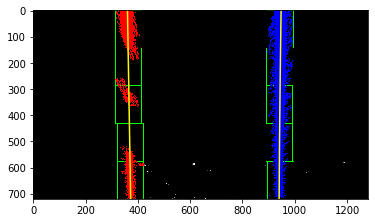

<Figure size 432x288 with 0 Axes>

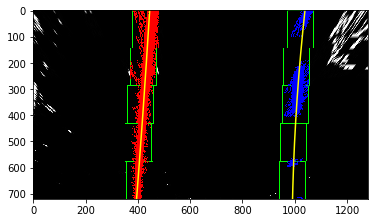

<Figure size 432x288 with 0 Axes>

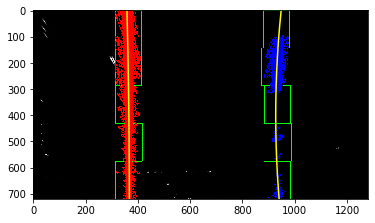

<Figure size 432x288 with 0 Axes>

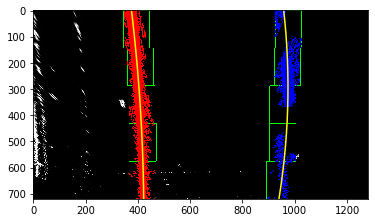

<Figure size 432x288 with 0 Axes>

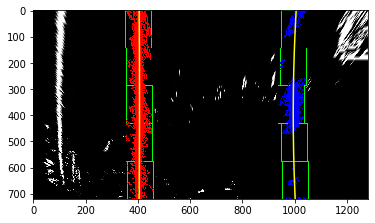

<Figure size 432x288 with 0 Axes>

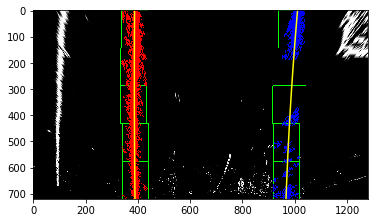

<Figure size 432x288 with 0 Axes>

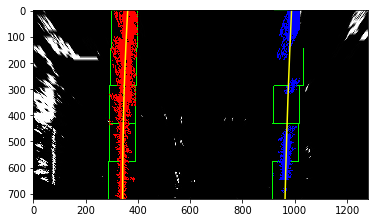

<Figure size 432x288 with 0 Axes>

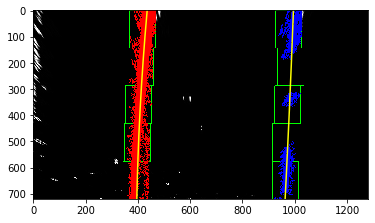

In [42]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    binary_warped_histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(binary_warped_histogram.shape[0]//2)
    leftx_base = np.argmax(binary_warped_histogram[0:midpoint])
    rightx_base = np.argmax(binary_warped_histogram[midpoint:]) + midpoint

    #print(binary_warped.shape)
    #print(leftx_base)
    #print(rightx_base)
    
    #plt.figure()
    #plt.plot(binary_warped_histogram)
    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 5
    # Set the width of the windows +/- margin
    margin = 50
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img, left_lane_inds, right_lane_inds 


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img, left_lane_inds, right_lane_inds = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]



    return [out_img, left_fitx, right_fitx, ploty, left_fit, right_fit, left_lane_inds, right_lane_inds]

warped_images2 = glob.glob('./warped_images/*.jpg')
#print(raw_images)

for fname6 in warped_images2:
    plt.figure()
    img6 = cv2.imread(fname6)
    img6_gray = cv2.cvtColor(img6,cv2.COLOR_BGR2GRAY)
    lane_fitted_images, left_fitx, right_fitx, ploty, left_fit, right_fit, left_lane_inds, right_lane_inds = fit_polynomial(img6_gray)
    #cv2.imwrite(os.path.join('./lane_fitted_images/',fname6[16:]), lane_fitted_images)
    #print(fname6[14:])
    #lr,rr=measure_curvature_real(ploty, left_fitx, right_fitx)
    #print(lr,rr)
    plt.figure()
    #plt.plot(img_histogram)
    plt.imshow(lane_fitted_images)
    #test=img6[: : 1]
    #print(img6_gray.shape)
    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    
    plt.savefig(os.path.join('./lane_fitted_images/',fname6[16:-3]))




##  Functions to avoid duplication of sliding window

<Figure size 432x288 with 0 Axes>

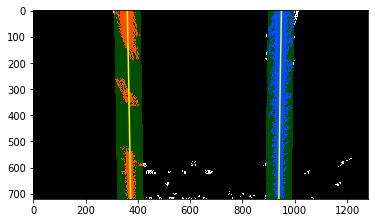

<Figure size 432x288 with 0 Axes>

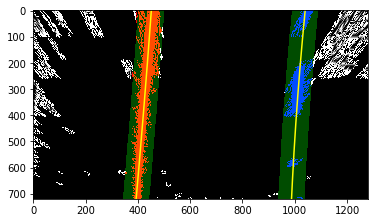

<Figure size 432x288 with 0 Axes>

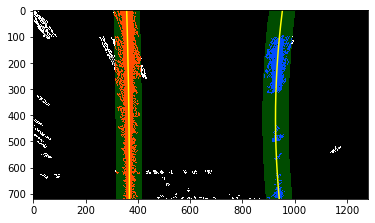

<Figure size 432x288 with 0 Axes>

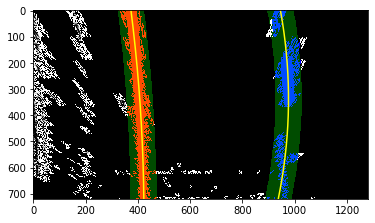

<Figure size 432x288 with 0 Axes>

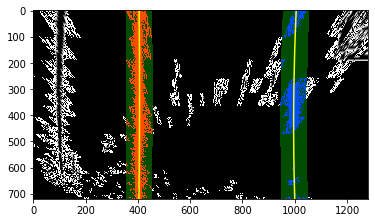

<Figure size 432x288 with 0 Axes>

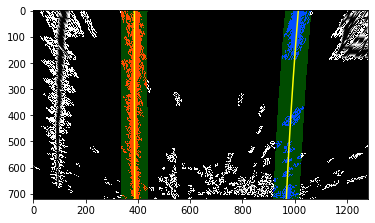

<Figure size 432x288 with 0 Axes>

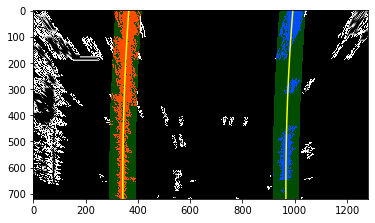

<Figure size 432x288 with 0 Axes>

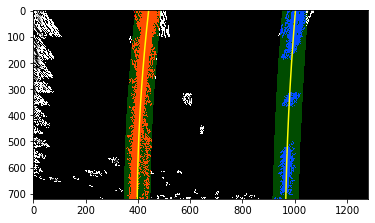

In [43]:
def fit_poly(img_shape, leftx, lefty, rightx, righty):
     ## Fit a second order polynomial to each with np.polyfit() on the lane pixels
     ##detected in current step
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting: these are just y values
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty, left_fit, right_fit

def search_around_poly(binary_warped, left_fit, right_fit):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    margin = 50

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty, left_fit, right_fit = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return [result,left_fit, right_fit, ploty, left_fitx, right_fitx, leftx, lefty, rightx, righty, left_lane_inds, right_lane_inds]


warped_images2 = glob.glob('./warped_images/*.jpg')
#print(raw_images)

for fname6 in warped_images2:
    plt.figure()
    img6 = cv2.imread(fname6)
    img6_gray = cv2.cvtColor(img6,cv2.COLOR_BGR2GRAY)
    lane_fitted_images, left_fitx, right_fitx, ploty, left_fit, right_fit, left_lane_inds, right_lane_inds = fit_polynomial(img6_gray)
    #print(left_fitx)
    #print(right_fitx)
    #print(ploty)
    
    prev_lane_fitted_images, left_fit, right_fit, ploty, left_fitx, right_fitx, leftx, lefty, rightx, righty, left_lane_inds, right_lane_inds = search_around_poly(img6_gray, left_fit, right_fit)
    #cv2.imwrite(os.path.join('./prev_lane_fitted_images/',fname6[16:]), prev_lane_fitted_images)
    #print(fname6[14:])
    #lr,rr=measure_curvature_real(ploty, left_fitx, right_fitx)
    #print(lr,rr)
    plt.figure()
    #plt.plot(img_histogram)
    plt.imshow(prev_lane_fitted_images)
    #test=img6[: : 1]
    #print(img6_gray.shape)
    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.savefig(os.path.join('./prev_lane_fitted_images/',fname6[16:-3]))    



## Functions to determine the curvature of the lane and vehicle position

870.1901033644394 627.7045802868089
435.53975167930975 131.32943116197993
225.72403202581953 31.14966583017251
59.20375191459505 18.76268036363422
320.7683372007036 92.10720637722858
756.7769380898975 188.33846257400327
86.68606063715495 78.72169479659082
65.38645772586797 107.00591347426202


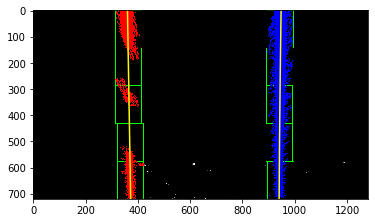

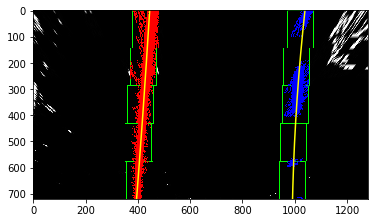

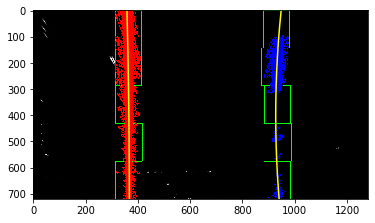

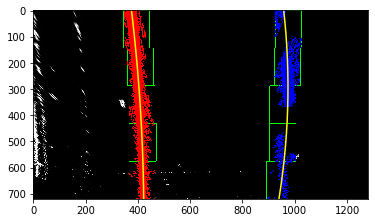

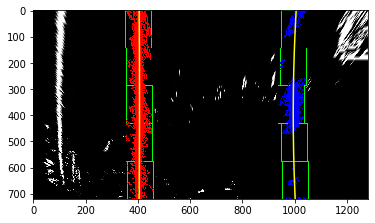

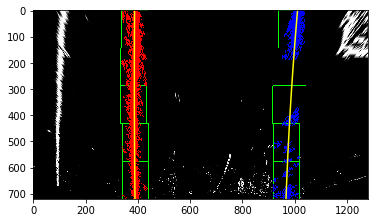

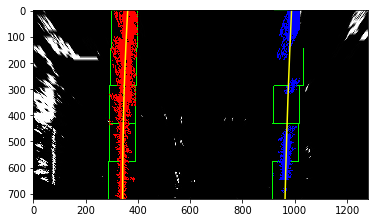

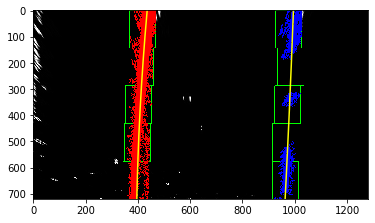

In [44]:
def measure_curvature_pixels(ploty, left_fit, right_fit):
    '''
    Calculates the curvature of polynomial functions in pixels.
    '''

    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    return left_curverad, right_curverad

def measure_curvature_real(img6_gray, ploty, left_fit, right_fit):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    prev_lane_fitted_images, left_fit, right_fit, ploty, left_fitx, right_fitx, leftx, lefty, rightx, righty, left_lane_inds, right_lane_inds = search_around_poly(img6_gray, left_fit, right_fit)
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 3/320 # meters per pixel in y dimension
    xm_per_pix = 3.7/400 # meters per pixel in x dimension
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculation of R_curve (radius of curvature)
    #left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    #right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        #left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
        #right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
        # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    return left_curverad, right_curverad, 0

warped_images2 = glob.glob('./warped_images/*.jpg')
#print(raw_images)

for fname6 in warped_images2:
    plt.figure()
    img6 = cv2.imread(fname6)
    img6_gray = cv2.cvtColor(img6,cv2.COLOR_BGR2GRAY)
    lane_fitted_images, left_fitx, right_fitx, ploty, left_fit, right_fit, left_lane_inds, right_lane_inds = fit_polynomial(img6_gray)
    lr,rr, off_center=measure_curvature_real(img6_gray,ploty, left_fit, right_fit)
    #print(lr,rr)
    
    plt.imshow(lane_fitted_images)
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    #plt.savefig(os.path.join('./lane_fitted_images/',fname6[16:]))
    


## Warp the detected lane boundaries back onto the original image

In [45]:
def unwarp_image(warped, undist, left_fitx, right_fitx, ploty):   
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    src = np.float32([[212,700], [1090,700], [737,480], [550,480]])
    #print([corners[0,0], corners[7,0], corners[47,0], corners[40,0]])
    # c) define 4 destination points dst = np.float32([[,],[,],[,],[,]])
    dst = np.float32([[350,720],[950,720],[950,0],[350,0]])
    # d) use cv2.getPerspectiveTransform() to get M, the transform matrix
    Minv=cv2.getPerspectiveTransform(dst, src)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    #plt.imshow(result)
    return result

def addText(img,lr,rr,off_center,font):
    img=cv2.putText(img,'Radius of curvature is',(10,10), font, 1,(255,255,255),2)
    img=cv2.putText(img,'Vehicle is ',(10,10), font, 1,(255,255,255),2)
    return img

## Test unwarping and overlaying curvature information on test images

<Figure size 432x288 with 0 Axes>

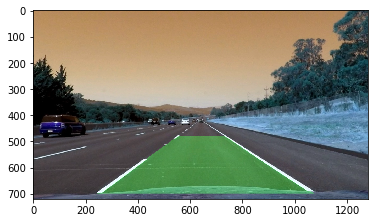

<Figure size 432x288 with 0 Axes>

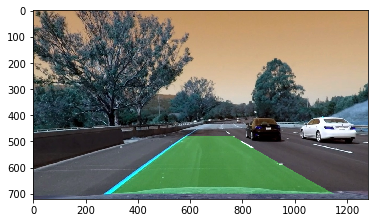

<Figure size 432x288 with 0 Axes>

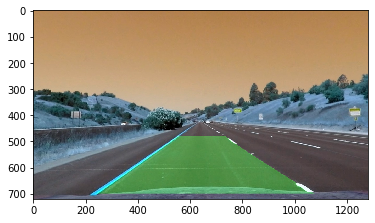

<Figure size 432x288 with 0 Axes>

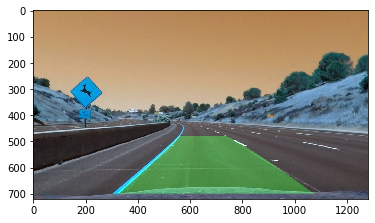

<Figure size 432x288 with 0 Axes>

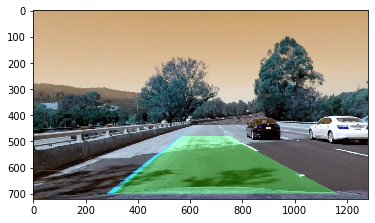

<Figure size 432x288 with 0 Axes>

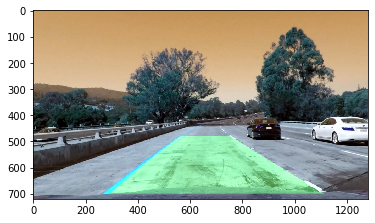

<Figure size 432x288 with 0 Axes>

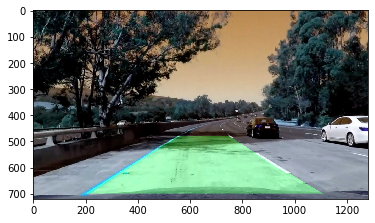

<Figure size 432x288 with 0 Axes>

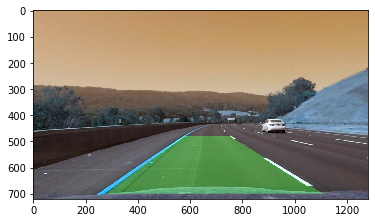

In [46]:
for fname6 in warped_images2:
    plt.figure()
    img6 = cv2.imread(fname6)
    undist = cv2.imread(os.path.join('./calibrated_images/',fname6[16:]))
    img6_gray = cv2.cvtColor(img6,cv2.COLOR_BGR2GRAY)
    lane_fitted_images, left_fitx, right_fitx, ploty, left_fit, right_fit, left_lane_inds, right_lane_inds = fit_polynomial(img6_gray)
    
    unwarped_lane_fitted_images=unwarp_image(img6_gray, undist, left_fitx, right_fitx, ploty)
    
    lr,rr,off_center= measure_curvature_real(img6_gray, ploty, left_fit, right_fit)
    #text_unwarped_lane_fitted_images=addText(unwarped_lane_fitted_images,lr,rr,off_center,10)
    
    plt.figure()
    #plt.plot(img_histogram)
    plt.imshow(unwarped_lane_fitted_images)
    cv2.imwrite(os.path.join('./unwarped_lane_fitted_images/',fname6[16:]), unwarped_lane_fitted_images)
    #print(fname6[14:])
    #test=img6[: : 1]
    #print(img6_gray.shape)
    # Plots the left and right polynomials on the lane lines
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')

## THE FOLLOWING SECTION WILL DEVELOP A CONCISE PIPELINE FOR ADVANCE LANE FINDING IN VIDEOS

## Import packages

In [48]:
# Import everything needed to edit/save/watch video clips
%matplotlib inline
from moviepy.editor import VideoFileClip
from IPython.display import HTML

## Add modified helper functions from above

In [49]:
# Function to undistort images
def cal_undistort(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera() and cv2.undistort()
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1],None,None)
    #pickle.dump()
    undist= cv2.undistort(img, mtx, dist, None, mtx)
    #undist = np.copy(img)  # Delete this line
    return [undist, ret, mtx, dist]

# Function to transform images into thresholded binary images
def binary_transformation(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    binary=cv2.bitwise_or(sxbinary,s_binary)
    
    # Stack each channel
    #color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    return binary

def warp_image(binary_image):   
    
    imgx=binary_image.shape[1]
    imgy=binary_image.shape[0]
    src = np.float32([[212,700], [1090,700], [737,480], [550,480]])
    #print([corners[0,0], corners[7,0], corners[47,0], corners[40,0]])
    # c) define 4 destination points dst = np.float32([[,],[,],[,],[,]])
    dst = np.float32([[350,720],[950,720],[950,0],[350,0]])
    # d) use cv2.getPerspectiveTransform() to get M, the transform matrix
    M=cv2.getPerspectiveTransform(src, dst)
    # e) use cv2.warpPerspective() to warp your image to a top-down view
    warped=cv2.warpPerspective(binary_image, M, (imgx, imgy),flags=cv2.INTER_LINEAR)
        
    return warped

def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    binary_warped_histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(binary_warped_histogram.shape[0]//2)
    leftx_base = np.argmax(binary_warped_histogram[0:midpoint])
    rightx_base = np.argmax(binary_warped_histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 5
    # Set the width of the windows +/- margin
    margin = 50
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img, left_lane_inds, right_lane_inds 


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img, left_lane_inds, right_lane_inds = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
    return [left_fitx, right_fitx, ploty, left_fit, right_fit, left_lane_inds, right_lane_inds]

def fit_poly(img_shape, leftx, lefty, rightx, righty):
     ## Fit a second order polynomial to each with np.polyfit() on the lane pixels
     ##detected in current step
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting: these are just y values
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty, left_fit, right_fit

def search_around_poly(binary_warped, left_fit, right_fit):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    margin = 50

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty, left_fit, right_fit = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    return [left_fitx, right_fitx, ploty, left_fit, right_fit, left_lane_inds, right_lane_inds]



def unwarp_image(warped, undist, left_fitx, right_fitx, ploty):   
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    src = np.float32([[212,700], [1090,700], [737,480], [550,480]])
    #print([corners[0,0], corners[7,0], corners[47,0], corners[40,0]])
    # c) define 4 destination points dst = np.float32([[,],[,],[,],[,]])
    dst = np.float32([[350,720],[950,720],[950,0],[350,0]])
    # d) use cv2.getPerspectiveTransform() to get M, the transform matrix
    Minv=cv2.getPerspectiveTransform(dst, src)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    #plt.imshow(result)
    return result

def measure_curvature_real(img6_gray, ploty, left_fit, right_fit, left_lane_inds, right_lane_inds):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Grab activated pixels
    nonzero = img6_gray.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 3/120 # meters per pixel in y dimension
    xm_per_pix = 3.7/360 # meters per pixel in x dimension
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculation of R_curve (radius of curvature)
    #left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    #right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        #left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
        #right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
        # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    car_position = img6_gray.shape[1]/2
    h=img6_gray.shape[0]
    lane_lx = left_fit[0]*h**2 + left_fit[1]*h + left_fit[2]
    lane_rx = right_fit[0]*h**2 + right_fit[1]*h + right_fit[2]
    lane_center_position = (lane_lx + lane_rx) /2
    center_dist = (car_position - lane_center_position) * xm_per_pix
    
    return left_curverad, right_curverad, center_dist

def addText(img,lr,rr,off_center):
    font=cv2.FONT_HERSHEY_SIMPLEX
    curv_rad=(lr+rr)/2
    text = 'Curve radius: ' + '{:04.2f}'.format(curv_rad) + 'm'
    cv2.putText(img,text,(30,60), font, 1,(255,255,255),2)
    
    direction = ''
    if off_center > 0:
        direction = 'right'
    elif off_center < 0:
        direction = 'left'
    abs_center_dist = abs(off_center)
    text = '{:04.3f}'.format(abs_center_dist) + 'm ' + direction + ' of center'
    cv2.putText(img,text,(30,120), font, 1,(255,255,255),2)
    return img



## Make a line class

In [50]:
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = []  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #number of detected pixels
        self.px_count = None
    def add_fit_lines(self, fit, inds):
        if fit is not None:
            self.detected = True
            self.px_count = np.count_nonzero(inds)
            self.current_fit.append(fit)
            if len(self.current_fit) > 5:
                self.current_fit = self.current_fit[len(self.current_fit)-5:]
            self.best_fit = np.average(self.current_fit, axis=0)
        else:
            self.detected = False
            if len(self.current_fit) > 0:
                self.current_fit = self.current_fit[:len(self.current_fit)-1]
            if len(self.current_fit) > 0:
                self.best_fit = np.average(self.current_fit, axis=0)

## Process video here

In [51]:
def process_image(image):
    
    undistorted_image, ret, mtx, dist = cal_undistort(image, objpoints, imgpoints)
    binary_image=binary_transformation(undistorted_image)
    warped_image=warp_image(binary_image)
    
    if not left_line.detected or not right_line.detected:
        left_fitx, right_fitx, ploty, left_fit, right_fit, left_lane_inds, right_lane_inds = fit_polynomial(warped_image)
    else:
        left_fitx, right_fitx, ploty, left_fit, right_fit, left_lane_inds, right_lane_inds = search_around_poly(warped_image, left_line.best_fit, right_line.best_fit)
    
       # l_fit, r_fit, l_lane_inds, r_lane_inds = polyfit_prev_fit(img_bin, l_line.best_fit, r_line.best_fit)
        
    left_line.add_fit_lines(left_fit, left_lane_inds)
    right_line.add_fit_lines(right_fit, right_lane_inds)
    
    #lane_fitted_images, left_fitx, right_fitx, ploty = fit_polynomial(warped_image)
    unwarped_lane_fitted_images=unwarp_image(warped_image, image, left_fitx, right_fitx, ploty)
    lr,rr,center=measure_curvature_real(warped_image, ploty, left_fit, right_fit, left_lane_inds, right_lane_inds)
    unwarped_lane_fitted_images_wtext=addText(unwarped_lane_fitted_images,lr,rr,center)
    
    return unwarped_lane_fitted_images_wtext

white_output = './project_video_output.mp4'


left_line = Line()
right_line = Line()
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("./project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video ./challenge_video_output.mp4
[MoviePy] Writing video ./challenge_video_output.mp4


100%|██████████| 30/30 [00:21<00:00,  1.40it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./challenge_video_output.mp4 

CPU times: user 1min 13s, sys: 919 ms, total: 1min 14s
Wall time: 21.7 s
